# Forecasting using Autogluon

## Preparing the Dataset

Let's take a look first at the raw data:

In [1]:
%load_ext autoreload
%autoreload 2

import os
WORKING_DIRECTORY: str = "/Users/cgavidia-calderon/Documents/GitHub/OpenMarsML/dust_forecast"
os.chdir(WORKING_DIRECTORY)

import logging
logging.basicConfig(level=logging.INFO)

from data_utils import DATETIME_COLUMN
import pandas as pd
TRAINING_DATA_FILE: str = "/Users/cgavidia-calderon/Documents/GitHub/OpenMarsML/data/data_files/insight_openmars_training_time.csv"
PREDICTOR_FOLDER:str = None

training_dataframe: pd.DataFrame = pd.read_csv(TRAINING_DATA_FILE, parse_dates=[DATETIME_COLUMN])
training_dataframe


,Time,Ls,LT,Tsurf,Psurf,CO2ice,cloud,vapour,u_wind,v_wind,dust,temp
0,1998-07-15 21:23:39,0.555,9.0,264.042,721.113,0.0,0.092,0.027,-7.451,8.604,0.428,179.686
1,1998-07-15 23:26:53,0.598,11.0,274.736,705.090,0.0,0.145,0.026,-7.053,4.934,0.427,174.502
2,1998-07-16 01:30:07,0.640,13.0,265.939,700.691,0.0,0.105,0.026,-6.825,-0.063,0.427,173.429
3,1998-07-16 03:33:21,0.683,15.0,238.624,697.252,0.0,0.134,0.025,-5.373,-4.048,0.426,173.556
4,1998-07-16 05:36:35,0.725,17.0,213.634,717.146,0.0,0.139,0.026,-3.899,-3.133,0.426,174.789
...,...,...,...,...,...,...,...,...,...,...,...,...
72191,2015-06-18 04:24:40,359.795,7.0,235.054,730.498,0.0,0.019,0.014,1.868,8.633,0.388,191.498
72192,2015-06-18 06:27:53,359.838,9.0,264.949,730.753,0.0,0.015,0.014,-6.924,6.590,0.388,187.591
72193,2015-06-18 08:31:07,359.880,11.0,275.776,703.987,0.0,0.012,0.014,-4.681,2.727,0.388,185.172
72194,2015-06-18 10:34:21,359.923,13.0,266.946,695.836,0.0,0.012,0.014,-3.277,-5.484,0.388,184.216


In [2]:
training_dataframe.describe()

,Time,Ls,LT,Tsurf,Psurf,CO2ice,cloud,vapour,u_wind,v_wind,dust,temp
count,72196,72196.000000,72196.000000,72196.000000,72196.000000,72196.0,72196.000000,72196.000000,72196.000000,72196.00000,72196.000000,72196.000000
mean,2006-12-31 17:25:41.788063232,169.699903,12.000000,221.822267,731.683035,0.0,0.038435,0.015826,0.220215,1.44027,0.457868,184.425504
min,1998-07-15 21:23:39,0.000000,1.000000,179.021000,593.572000,0.0,0.000000,0.002000,-18.546000,-20.31800,0.000000,144.080000
25%,2002-10-08 06:05:25,78.234000,7.000000,195.718000,696.571000,0.0,0.000000,0.013000,-2.480000,-1.61825,0.216000,175.625750
50%,2006-12-31 17:47:42,159.002500,12.000000,209.725500,738.898000,0.0,0.011000,0.015000,0.807000,1.52050,0.346000,184.401000
75%,2011-03-26 04:43:14,261.545750,17.000000,248.303250,767.305250,0.0,0.055000,0.018000,2.405000,4.18100,0.544000,194.807250
max,2015-06-18 12:37:35,359.992000,23.000000,289.984000,841.617000,0.0,0.863000,0.038000,17.213000,17.50300,5.333000,242.430000
std,NaN,105.241749,6.903982,30.912305,47.995385,0.0,0.060889,0.004600,4.060972,4.91390,0.439075,14.658462


We have data from 1998 to 2015. Not sure if its evenly sampled though. Let's try to transform this to wide format:

In [3]:
from data_utils import to_wide_format

wide_training_dataframe: pd.DataFrame = to_wide_format(training_dataframe, time_column=DATETIME_COLUMN)
wide_training_dataframe

INFO:root:Metric: Ls Time steps: 72196
INFO:root:Metric: LT Time steps: 72196
INFO:root:Metric: Tsurf Time steps: 72196
INFO:root:Metric: Psurf Time steps: 72196
INFO:root:Metric: CO2ice Time steps: 72196
INFO:root:Metric: cloud Time steps: 72196
INFO:root:Metric: vapour Time steps: 72196
INFO:root:Metric: u_wind Time steps: 72196
INFO:root:Metric: v_wind Time steps: 72196
INFO:root:Metric: dust Time steps: 72196
INFO:root:Metric: temp Time steps: 72196
INFO:root:Number of metrics: 11


,Time,target,Metric
0,1998-07-15 21:23:39,0.555,Ls
1,1998-07-15 23:26:53,0.598,Ls
2,1998-07-16 01:30:07,0.640,Ls
3,1998-07-16 03:33:21,0.683,Ls
4,1998-07-16 05:36:35,0.725,Ls
...,...,...,...
72191,2015-06-18 04:24:40,191.498,temp
72192,2015-06-18 06:27:53,187.591,temp
72193,2015-06-18 08:31:07,185.172,temp
72194,2015-06-18 10:34:21,184.216,temp


11 time series, and 70K time steps. If recall correctly, data is sampled every two hours.

## Attempting a Forecast

First, let's create a `TimeSeriesDataFrame` instance. We are not including static features per time series.

In [4]:
from autogluon.timeseries import TimeSeriesDataFrame
from data_utils import METRIC_COLUMN, DATETIME_COLUMN

FREQUENCY: str = "2H"
PREDICTION_LENGTH: int = 2500
EVALUATION_METRIC: str = "MASE"
PRESETS: str = "best_quality"
TIME_LIMIT: int = 4 * 60 * 60

time_series_dataframe: TimeSeriesDataFrame = TimeSeriesDataFrame.from_data_frame(
    wide_training_dataframe,
    id_column=METRIC_COLUMN,
    timestamp_column=DATETIME_COLUMN,
)

time_series_dataframe = time_series_dataframe.convert_frequency(freq=FREQUENCY)

training_time_series, testing_time_series = time_series_dataframe.train_test_split(PREDICTION_LENGTH)

training_time_series

/Users/cgavidia-calderon/miniconda3/envs/openmars/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


target
item_id timestamp                   
Ls      1998-07-15 20:00:00    0.555
        1998-07-15 22:00:00    0.598
        1998-07-16 00:00:00    0.640
        1998-07-16 02:00:00    0.683
        1998-07-16 04:00:00    0.725
...                              ...
temp    2014-11-21 20:00:00  202.828
        2014-11-21 22:00:00  207.714
        2014-11-22 00:00:00  207.886
        2014-11-22 02:00:00  205.223
        2014-11-22 04:00:00  201.428

[788491 rows x 1 columns]

Let's check the test-train split:

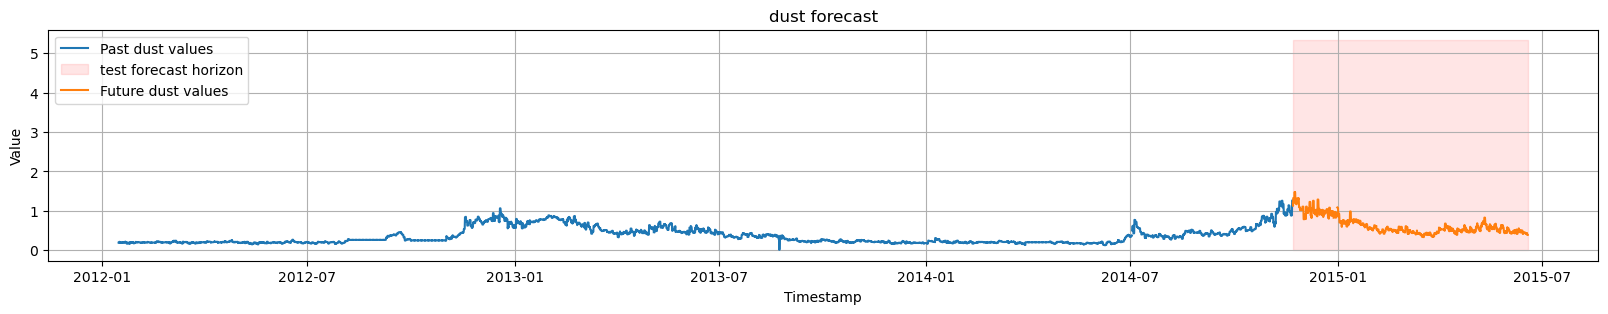

In [5]:
from plot_utils import plot_forecast

TIME_SERIES_ID: str = "dust"

plot_forecast(
    input_dataframe=training_time_series,
    expected_dataframe=testing_time_series,
    time_series_id=TIME_SERIES_ID,
    prediction_length=PREDICTION_LENGTH,
    training_values=PREDICTION_LENGTH*5
)

Let's take a look at how dust looks like:

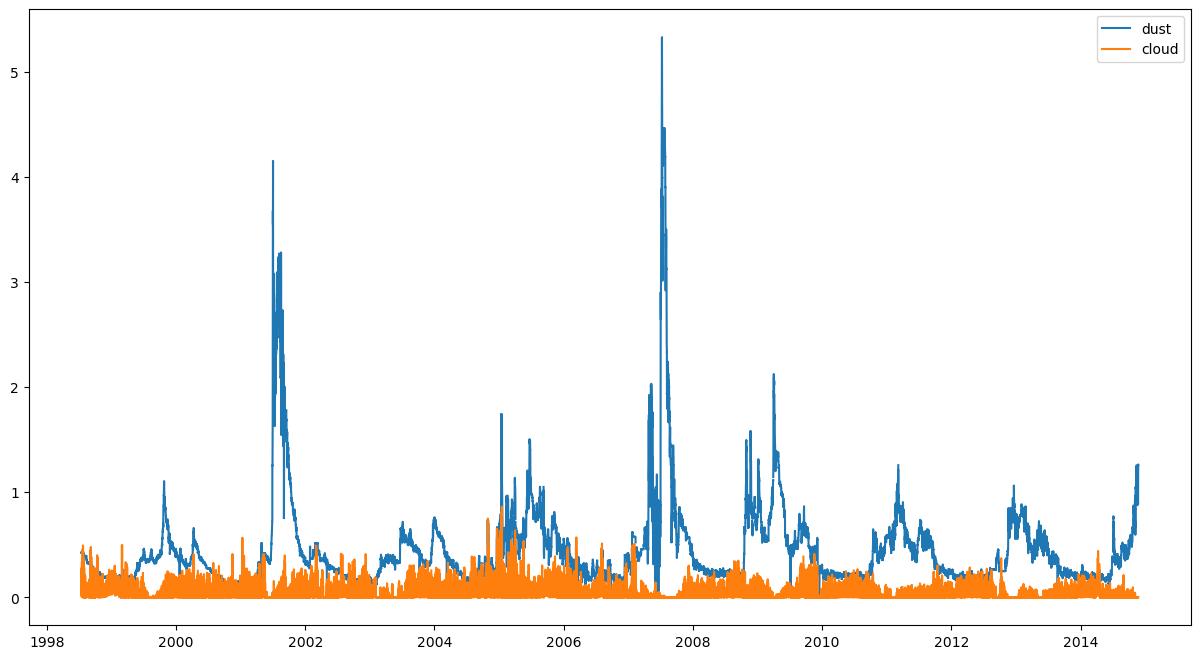

In [6]:
from plot_utils import plot_time_series

plot_time_series(training_time_series, [TIME_SERIES_ID, "cloud"])

Now, let's create the predictor instance. The ``NN5 Daily`` dataset has 111 time series with 80K time steps, and the prediction length is 56. Also the ``CIF 2016`` dataset has 72 time series and 6K time steps has a prediction length of 12. 

Let's start with 10.

In [7]:
from autogluon.timeseries import TimeSeriesPredictor

if not PREDICTOR_FOLDER:
    time_series_predictor: TimeSeriesPredictor = TimeSeriesPredictor(
        prediction_length=PREDICTION_LENGTH,
        eval_metric=EVALUATION_METRIC
    )
    
    time_series_predictor.fit(
        training_time_series,
        presets=PRESETS,
        time_limit=TIME_LIMIT
    )
else:
    time_series_predictor: TimeSeriesPredictor = TimeSeriesPredictor.load(PREDICTOR_FOLDER)

No path specified. Models will be saved in: "AutogluonModels/ag-20240401_180532"
Beginning AutoGluon training... Time limit = 14400s
AutoGluon will save models to 'AutogluonModels/ag-20240401_180532'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Sun Dec 17 22:12:45 PST 2023; root:xnu-8796.141.3.703.2~2/RELEASE_ARM64_T6000
CPU Count:          10
GPU Count:          0
Memory Avail:       16.09 GB / 32.00 GB (50.3%)
Disk Space Avail:   682.21 GB / 926.35 GB (73.6%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2500,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': '

Now, let's check the forecast on the training data:

In [8]:
training_predictions = time_series_predictor.predict(
    training_time_series)
training_predictions.head()

data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
Ls      2014-11-22 06:00:00  232.387791  219.713449  223.686887  226.782586   
        2014-11-22 08:00:00  233.294533  220.238659  225.080438  228.090315   
        2014-11-22 10:00:00  234.490792  219.937635  225.153106  228.639690   
        2014-11-22 12:00:00  233.585551  217.464768  222.980031  226.882390   
        2014-11-22 14:00:00  232.185503  214.867065  220.983775  225.225047   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
Ls      2014-11-22 06:00:00  229.731235  232.387791  234.989156  237.546326   
        2014-11-22 08:00:00  230.806966  233.294533  235.767079  238.866415   
        2014-11-22 10:00:00  231.465060  234.490792  237.374236  240.879066   
        2014-11-22 12:00:00  230.369753  233.585551  236.667031  240.315671   
        2014-11-22 14:00:00  229.048090  232.185503  235.973301  239.697447   

                                    0.8         0.9  
item_id timestamp                                    
Ls      2014-11-22 06:00:00  240.650323  244.620556  
        2014-11-22 08:00:00  241.955557  246.348041  
        2014-11-22 10:00:00  244.454666  249.119300  
        2014-11-22 12:00:00  244.165930  249.620241  
        2014-11-22 14:00:00  243.930615  249.529207

And let's plot the forecast for dust:

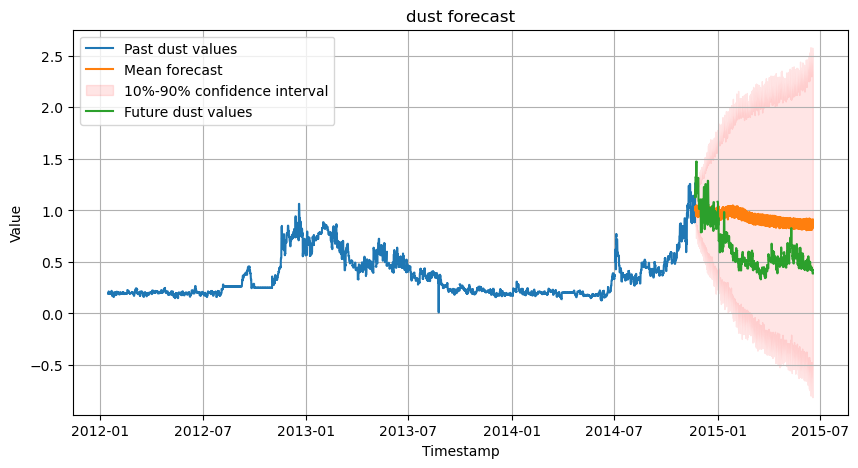

In [14]:
from plot_utils import plot_forecast


plot_forecast(
    input_dataframe=training_time_series, 
    expected_dataframe=testing_time_series, 
    forecast_dataframe=training_predictions, 
    time_series_id=TIME_SERIES_ID,
    prediction_length=PREDICTION_LENGTH, 
    training_values=PREDICTION_LENGTH*5, 
    figure_size=(10, 5))

## Model Evaluation

Let's take a look at what AutoGluon tried during training, over the testing time series:

In [15]:
time_series_predictor.leaderboard(testing_time_series)

data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-6.562547,-5.954652,0.652734,0.563445,2928.220583,11
1,WeightedEnsemble,-7.422107,-5.401154,158.057967,207.764627,10.324156,12
2,DeepAR,-8.797035,-13.384646,53.841963,73.477296,3379.123437,9
3,DynamicOptimizedTheta,-11.085863,-9.001345,25.171070,1.131457,7.384162,5
4,AutoARIMA,-11.150717,-7.133836,9.951759,64.085075,14.311260,6
5,TemporalFusionTransformer,-11.309906,-9.975820,1.424649,1.185727,3439.634077,10
6,SeasonalNaive,-11.360176,-8.944158,0.181705,0.176773,3.619521,1
7,CrostonSBA,-11.566231,-9.229332,1.455914,0.161285,5.240916,2
8,NPTS,-15.919560,-19.822564,66.889550,67.127030,67.750796,3
9,DirectTabular,-21.325822,-10.136575,1.533161,1.380324,58.053508,8
